In [28]:
import pandas as pd 
import numpy as np
import warnings
import sys
sys.path.append('../')
# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
# Modelos y precision
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error,  mean_absolute_error, r2_score #Regresion

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [4]:
from utils.funciones import apply_onehot_encoder

## CARGA Y LECTURA DE DATOS

In [6]:
df = pd.read_csv('../data/processed/train.csv') 

In [7]:
df

,Name,Location,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Edad
0,Honda,Chennai,46000,Petrol,Manual,3,9.75,1199.0,88.70,5.0,8.61,4.50,13
1,Toyota,Mumbai,36000,Diesel,Automatic,3,11.36,2755.0,171.50,8.0,21.00,17.50,8
2,Maruti,Kochi,25692,Petrol,Manual,3,21.56,1462.0,103.25,5.0,10.65,9.95,6
3,Mitsubishi,Delhi,110000,Diesel,Manual,3,13.50,2477.0,175.56,7.0,32.01,15.00,10
4,BMW,Kochi,32982,Diesel,Automatic,3,22.69,1995.0,190.00,5.0,47.87,18.55,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
809,Tata,Chennai,10000,Petrol,Manual,3,17.57,1193.0,88.70,5.0,7.77,4.00,8
810,Volkswagen,Mumbai,38000,Petrol,Manual,3,16.09,1598.0,103.50,5.0,11.91,3.25,13
811,Maruti,Pune,37208,Diesel,Manual,3,24.30,1248.0,88.50,5.0,9.93,7.43,8
812,Honda,Delhi,33746,Petrol,Manual,3,18.50,1198.0,86.80,5.0,6.63,3.20,11


# SELECCION DE VARIABLES

In [8]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
numeric_df = df[numeric_cols]

Realizamos la matriz de correlacion de Pearson

In [9]:
numeric_df.corr()

,Kilometers_Driven,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Edad
Kilometers_Driven,1.000000,-0.230460,0.026275,0.137274,0.013335,0.216340,-0.003443,-0.151082,0.519991
Owner_Type,-0.230460,1.000000,0.018131,-0.031040,-0.023288,0.004919,-0.049794,0.052413,-0.325707
Mileage,0.026275,0.018131,1.000000,-0.629252,-0.534014,-0.393840,-0.374001,-0.430773,0.100531
Engine,0.137274,-0.031040,-0.629252,1.000000,0.852293,0.412081,0.723666,0.694858,-0.010370
Power,0.013335,-0.023288,-0.534014,0.852293,1.000000,0.071671,0.871094,0.776023,0.022760
Seats,0.216340,0.004919,-0.393840,0.412081,0.071671,1.000000,-0.013832,0.042496,-0.074621
New_Price,-0.003443,-0.049794,-0.374001,0.723666,0.871094,-0.013832,1.000000,0.871256,0.025263
Price,-0.151082,0.052413,-0.430773,0.694858,0.776023,0.042496,0.871256,1.000000,-0.224598
Edad,0.519991,-0.325707,0.100531,-0.010370,0.022760,-0.074621,0.025263,-0.224598,1.000000


Las variables con la correlacion mas alta con la variable objetivo son las siguientes en su orden: 'Price', 'Power', 'Engine'. De momento descartamos las demas variables numericas del dataframe.

In [10]:
df_model = df[['Name', 'Location', 'Fuel_Type', 'Transmission', 'Price', 'Power', 'Engine', 'New_Price']]

In [11]:
df_model.head()

,Name,Location,Fuel_Type,Transmission,Price,Power,Engine,New_Price
0,Honda,Chennai,Petrol,Manual,4.50,88.70,1199.0,8.61
1,Toyota,Mumbai,Diesel,Automatic,17.50,171.50,2755.0,21.00
2,Maruti,Kochi,Petrol,Manual,9.95,103.25,1462.0,10.65
3,Mitsubishi,Delhi,Diesel,Manual,15.00,175.56,2477.0,32.01
4,BMW,Kochi,Diesel,Automatic,18.55,190.00,1995.0,47.87


# Division de Datos (X e y)

In [17]:
X = df_model.drop('New_Price', axis=1)
y = df_model['New_Price']

### Tratamiento variables categoricas

### LabelEncoder

In [18]:
# Realizamos la transformacion de la variable 'Name'

le = LabelEncoder()
X['Name']=le.fit_transform(X['Name'])

### OHE

In [19]:
var_1he = ['Location', 'Fuel_Type',	'Transmission']

X = apply_onehot_encoder(X, var_1he)

### Escalado de variables

In [21]:
var_ss = ['Price', 'Power',	'Engine']

SS = StandardScaler()
X[var_ss] = SS.fit_transform(X[var_ss])

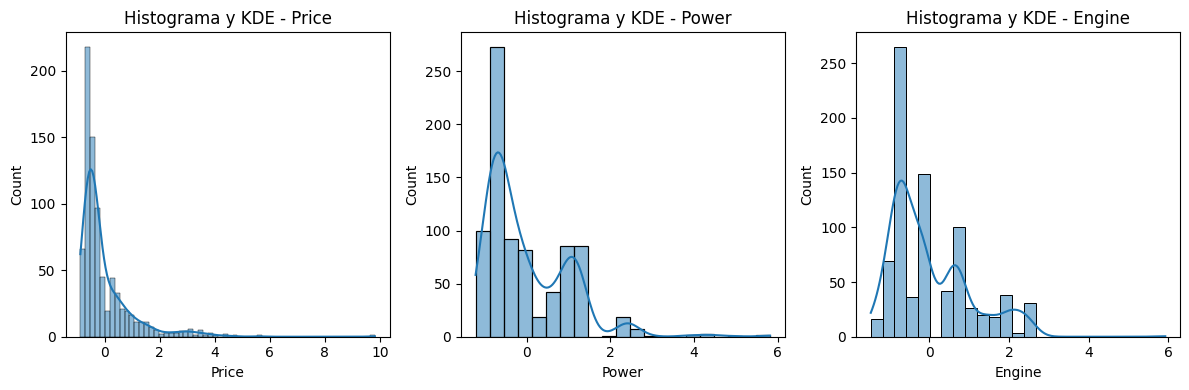

In [24]:
# Visualizar histograma y gráfico de densidad para la variable 1
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.histplot(X['Price'], kde=True)
plt.title('Histograma y KDE - Price')

# Visualizar histograma y gráfico de densidad para la variable 2
plt.subplot(1, 3, 2)
sns.histplot(X['Power'], kde=True)
plt.title('Histograma y KDE - Power')

# Visualizar histograma y gráfico de densidad para la variable 3
plt.subplot(1, 3, 3)
sns.histplot(X['Engine'], kde=True)
plt.title('Histograma y KDE - Engine')

plt.tight_layout()
plt.show()

### DIVIDIMOS EL DATASET

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Ensayo los modelos y sus metricas

In [30]:
# Definir modelos a evaluar
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor()
}

# Definir métricas de evaluación
metrics = {
    'Mean Squared Error': mean_squared_error,
    'Mean Absolute Error': mean_absolute_error,
    'R2 Score' : r2_score
}

# Configurar la validación cruzada (k-fold cross-validation)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Ciclo para evaluar modelos y métricas
results = []
for model_name, model in models.items():
    print(f"Modelo: {model_name}")
    for metric_name, metric_func in metrics.items():
        scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
        scores = -scores  # Convertir de negativo a positivo para errores cuadráticos
        mean_score = np.mean(scores)
        print(f"{metric_name}: {mean_score}")
        results.append({'Model': model_name, 'Metric': metric_name, 'Score': mean_score})
    print("\n")

# Crear un DataFrame con los resultados
results_df = pd.DataFrame(results)
print("Resultados Finales:")
print(results_df)

Modelo: Linear Regression
Mean Squared Error: 96.74514218323259
Mean Absolute Error: 96.74514218323259
R2 Score: 96.74514218323259


Modelo: Decision Tree
Mean Squared Error: 106.55026426759068
Mean Absolute Error: 104.2277255665379
R2 Score: 95.36222710558206


Modelo: Random Forest
Mean Squared Error: 54.810463550879966
Mean Absolute Error: 54.895451233206316
R2 Score: 53.58801503663972


Resultados Finales:
               Model               Metric       Score
0  Linear Regression   Mean Squared Error   96.745142
1  Linear Regression  Mean Absolute Error   96.745142
2  Linear Regression             R2 Score   96.745142
3      Decision Tree   Mean Squared Error  106.550264
4      Decision Tree  Mean Absolute Error  104.227726
5      Decision Tree             R2 Score   95.362227
6      Random Forest   Mean Squared Error   54.810464
7      Random Forest  Mean Absolute Error   54.895451
8      Random Forest             R2 Score   53.588015
